In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader 
from torchvision import datasets 
import torchvision.transforms as T 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
mytransform = T.ToTensor() 

train_data = datasets.MNIST(root = './', download=True, train = True, transform = mytransform)
test_data = datasets.MNIST(root = './', download=True, train = False, transform = mytransform)

100%|██████████| 9912422/9912422 [00:00<00:00, 92018510.17it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40635925.47it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21734143.49it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7476659.64it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
img, label = train_data[0]
img.shape

torch.Size([1, 28, 28])

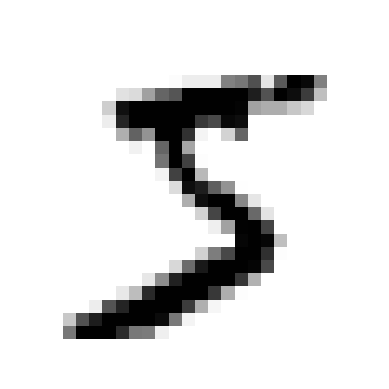

In [4]:
plt.imshow(img.reshape(28,28), cmap = 'gist_yarg');
plt.axis('off');

In [5]:
from torch.utils.data import DataLoader
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size = 100, shuffle=True)
test_loader =  DataLoader(test_data,  batch_size = 500, shuffle=False) 

In [6]:
from dataclasses import dataclass

@dataclass
class Loader:
    train: DataLoader  
    test:  DataLoader  
    
myloader = Loader(train = train_loader, test = test_loader)    
print(myloader)

Loader(train=<torch.utils.data.dataloader.DataLoader object at 0x7f1160a67a90>, test=<torch.utils.data.dataloader.DataLoader object at 0x7f1160a65300>)


In [7]:
for img, label in myloader.train:
    break 
img.shape 

torch.Size([100, 1, 28, 28])

In [8]:
myimages = img[:50].numpy()
myimages.shape

(50, 1, 28, 28)

In [9]:
myimages[0].shape

(1, 28, 28)

In [10]:
myimages[0].transpose(1,2,0).shape

(28, 28, 1)

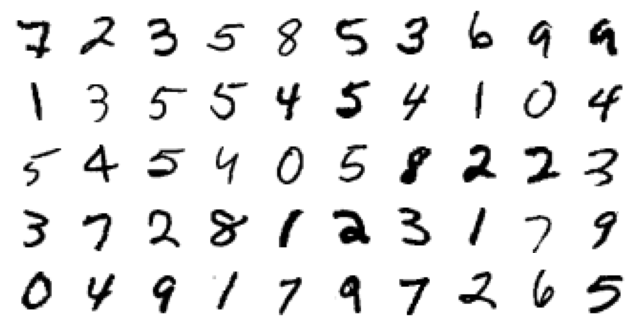

In [11]:
fig, ax = plt.subplots(nrows = 5, ncols = 10, figsize=(8,4), subplot_kw={'xticks': [], 'yticks': []})
for row in range(0,5):
    for col in range(0,10):
        myid = (10*row) + col 
        
        ax[row,col].imshow( myimages[myid].transpose(1,2,0), cmap = 'gist_yarg' ) 
        ax[row,col].axis('off')

In [12]:
class MultilayerPerceptron(nn.Module):
    
    def __init__(self, in_features = 784, out_features=10):
        
        super(MultilayerPerceptron, self).__init__()
        
        self.fc1 = nn.Linear(in_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_features)
            
    def forward(self, X):
        
        X = F.relu(self.fc1(X)) 
        X = F.relu(self.fc2(X)) 
        X = self.fc3(X)
        
        return F.log_softmax(X, dim = 1)

In [13]:
torch.manual_seed(101)

mymodel = MultilayerPerceptron() 
mymodel

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(mymodel.parameters(), lr = 1e-3)

In [15]:
params = [p.numel() for p in mymodel.parameters() if p.requires_grad]
np.sum(params)

105214

In [16]:
img.view(100,-1).shape

torch.Size([100, 784])

In [17]:
y_pred = mymodel( img.view(100,-1) )
y_pred.shape

torch.Size([100, 10])

In [18]:
val, idx = torch.max(y_pred, dim=1) 
idx

tensor([6, 2, 6, 8, 2, 2, 8, 7, 2, 2, 8, 6, 8, 2, 2, 2, 6, 8, 8, 2, 8, 2, 2, 2,
        8, 8, 2, 2, 6, 6, 6, 2, 6, 2, 6, 6, 2, 8, 8, 2, 8, 2, 2, 8, 6, 6, 2, 8,
        2, 2, 2, 2, 8, 8, 6, 2, 2, 6, 2, 2, 2, 8, 2, 2, 2, 2, 2, 8, 2, 2, 8, 2,
        2, 8, 2, 6, 7, 2, 7, 6, 2, 8, 6, 2, 2, 6, 2, 8, 2, 2, 8, 6, 8, 2, 6, 2,
        7, 8, 2, 2])

In [19]:
class Loss:
    train: list = []
    test: list = []
    

class Accuracy:
    train: list = []
    test: list = []

In [20]:
%%time

epochs = 10
for epoch in tqdm(range(epochs)):
    train_corr = 0
    test_corr = 0
    
    for batch, (img, label) in enumerate(myloader.train): 
        batch +=1
        y_pred = mymodel( img.view(100,-1) ) 
        loss = criterion(y_pred, label)
        
        _, prediction = torch.max(y_pred,dim = 1)
        train_corr += (prediction == label).sum() 

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if batch%200 == 0:
            acc = 100 * (train_corr.item() / (batch*100) ) 
            print( f'Epoch:{epoch:2d} batch: {batch:2d} loss: {loss.item():4.4f} Accuracy: {acc:4.4f} %' )

    Loss.train.append( loss.item() )
    accuracy = 100 * (train_corr.item() / (batch*100) ) 
    Accuracy.train.append( accuracy ) 

    
    with torch.no_grad():
        for batch, (img, label) in enumerate(myloader.test):
            batch +=1
            y_val = mymodel( img.view(500,-1) ) 
            _, predicted = torch.max( y_val, dim = 1)
            test_corr += (predicted == label).sum()
    
    loss = criterion( y_val,label )
    Loss.test.append( loss.item() ) 
    accuracy = 100 * (test_corr.item()/ (batch*500) ) 
    Accuracy.test.append( accuracy )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 batch: 200 loss: 0.2354 Accuracy: 83.2500 %
Epoch: 0 batch: 400 loss: 0.3537 Accuracy: 87.5275 %
Epoch: 0 batch: 600 loss: 0.1365 Accuracy: 89.5733 %


 10%|█         | 1/10 [00:09<01:22,  9.22s/it]

Epoch: 1 batch: 200 loss: 0.2447 Accuracy: 94.8050 %
Epoch: 1 batch: 400 loss: 0.1454 Accuracy: 95.0625 %
Epoch: 1 batch: 600 loss: 0.0730 Accuracy: 95.3567 %


 20%|██        | 2/10 [00:18<01:11,  9.00s/it]

Epoch: 2 batch: 200 loss: 0.0872 Accuracy: 96.5000 %
Epoch: 2 batch: 400 loss: 0.0670 Accuracy: 96.5950 %
Epoch: 2 batch: 600 loss: 0.0689 Accuracy: 96.6783 %


 30%|███       | 3/10 [00:27<01:02,  8.97s/it]

Epoch: 3 batch: 200 loss: 0.1164 Accuracy: 97.6650 %
Epoch: 3 batch: 400 loss: 0.0581 Accuracy: 97.4850 %
Epoch: 3 batch: 600 loss: 0.0319 Accuracy: 97.4967 %


 40%|████      | 4/10 [00:36<00:54,  9.02s/it]

Epoch: 4 batch: 200 loss: 0.1170 Accuracy: 98.1200 %
Epoch: 4 batch: 400 loss: 0.0467 Accuracy: 97.9775 %
Epoch: 4 batch: 600 loss: 0.0510 Accuracy: 97.9967 %


 50%|█████     | 5/10 [00:45<00:44,  8.99s/it]

Epoch: 5 batch: 200 loss: 0.0087 Accuracy: 98.3950 %
Epoch: 5 batch: 400 loss: 0.0391 Accuracy: 98.5100 %
Epoch: 5 batch: 600 loss: 0.0528 Accuracy: 98.4317 %


 60%|██████    | 6/10 [00:54<00:35,  8.99s/it]

Epoch: 6 batch: 200 loss: 0.0335 Accuracy: 98.8850 %
Epoch: 6 batch: 400 loss: 0.0724 Accuracy: 98.7400 %
Epoch: 6 batch: 600 loss: 0.0840 Accuracy: 98.7100 %


 70%|███████   | 7/10 [01:02<00:26,  8.97s/it]

Epoch: 7 batch: 200 loss: 0.0833 Accuracy: 99.2050 %
Epoch: 7 batch: 400 loss: 0.0840 Accuracy: 99.0525 %
Epoch: 7 batch: 600 loss: 0.0392 Accuracy: 98.9750 %


 80%|████████  | 8/10 [01:12<00:18,  9.03s/it]

Epoch: 8 batch: 200 loss: 0.0069 Accuracy: 99.2050 %
Epoch: 8 batch: 400 loss: 0.0061 Accuracy: 99.1375 %
Epoch: 8 batch: 600 loss: 0.0906 Accuracy: 99.1267 %


 90%|█████████ | 9/10 [01:21<00:08,  9.00s/it]

Epoch: 9 batch: 200 loss: 0.0048 Accuracy: 99.4350 %
Epoch: 9 batch: 400 loss: 0.0101 Accuracy: 99.3250 %
Epoch: 9 batch: 600 loss: 0.0152 Accuracy: 99.2967 %


100%|██████████| 10/10 [01:30<00:00,  9.00s/it]

CPU times: user 2min 16s, sys: 421 ms, total: 2min 16s
Wall time: 1min 30s


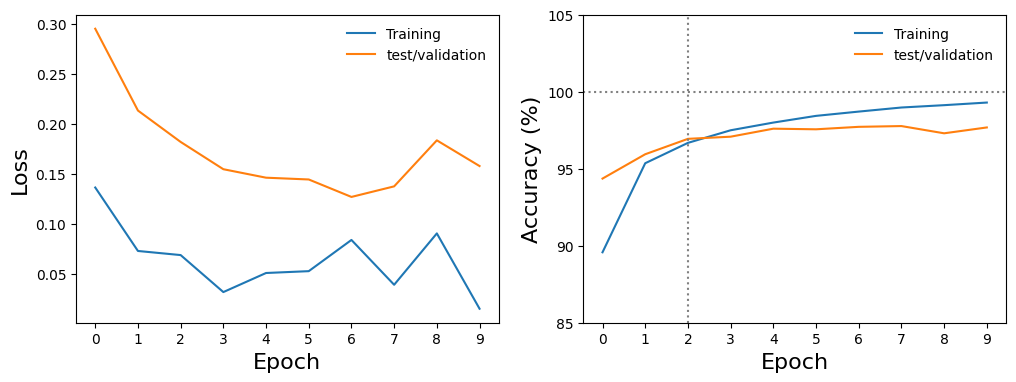

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(Loss.train, label = 'Training')
ax[0].plot(Loss.test, label='test/validation')
ax[0].set_ylabel('Loss', fontsize=16)


ax[1].plot(Accuracy.train, label = 'Training')
ax[1].plot(Accuracy.test, label='test/validation')
ax[1].set_yticks(range(85,110,5))
ax[1].axvline(x=2, color='gray', linestyle=':')
ax[1].axhline(y=100, color='gray', linestyle=':')
ax[1].set_ylabel('Accuracy (%)', fontsize=16)

for myax in ax:
    myax.set_xlabel('Epoch', fontsize=16)
    myax.set_xticks(range(epochs))
    myax.legend(frameon=False)

In [22]:
with torch.no_grad():
    correct = 0
    
    for X, y_label in test_loader:
            y_val = mymodel( X.view(X.shape[0],-1) ) 
            _, predicted = torch.max( y_val, dim = 1)
            correct += (predicted == y_label).sum()

print(f'Test accuracy: = {correct.item()*100/(len(test_data)):2.4f} %')

Test accuracy: = 97.6800 %


In [23]:
from sklearn.metrics import confusion_matrix  
confusion_array = confusion_matrix(y_true = y_label,y_pred = predicted)
confusion_array

array([[49,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0, 60,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  0, 43,  1,  0,  0,  0,  1,  1,  0],
       [ 0,  0,  0, 51,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 48,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0, 39,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  1, 47,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 59,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 48,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, 42]])

<Axes: >

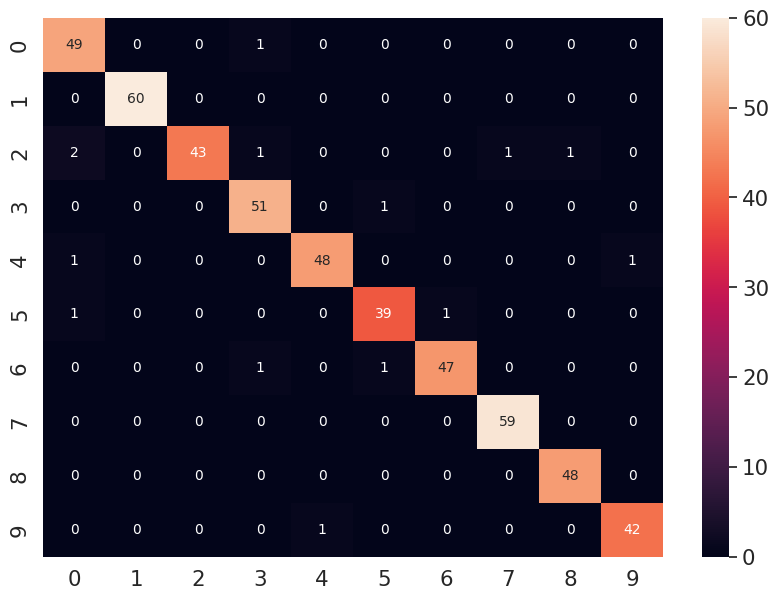

In [24]:
import pandas as pd
import seaborn as sn
df_cm = pd.DataFrame(confusion_array, range(10), range(10))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10})